In [168]:
%pylab inline

import numpy as np
import pandas as pd
import pandas_profiling
import json
import pymysql
import pickle
import seaborn as sns
import csv
import re

from keplergl import KeplerGl 
from h3 import h3

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data

## Business

In [73]:
conn = pymysql.connect('localhost', 'anderson', db='yelp', charset='utf8')

 * state: NV 가 groupby sum 했을때 review_count 가장많은 2243534 갯수가 나왔다 -> 분석의 시간을 단축하기 위해서 해당 지역만 한다

Hotel: (1669, 14)
전체: (1653, 15)
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
shape: (1653, 12)


,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,categories,h3,rank
0,Jff5hTK1ZMLKS06sOSNWdA,radisson hotel & conference centre calgary air...,Calgary,AB,51.111892,-113.980480,3.5,14,1,"hotels & travel, hotels, event planning & serv...",8712ea6ceffffff,49.0
1,N2G7ySm6R-jYrHvDAV2Ndw,holiday inn express & suites pittsburgh sw - s...,Canonsburg,PA,40.274538,-80.169376,5.0,7,1,"hotels, event planning & services, hotels & tr...",872a846a3ffffff,35.0
2,mruax-1iDdb8GlAKwLy8JQ,hotel indigo toronto airport,Toronto,ON,43.678900,-79.591488,3.0,15,0,"airports, hotels, event planning & services, h...",872b9bcf4ffffff,45.0
3,W7QOR9r7mm6ak3DURkSwxg,sandman hotel & suites calgary west,Calgary,AB,51.085273,-114.208982,3.0,8,1,"hotels, hotels & travel, event planning & serv...",8712ccd04ffffff,24.0
4,9eK8T1EUoCuzjsrtNa522A,holiday inn phoenix - chandler,Chandler,AZ,33.248029,-111.866267,3.5,27,1,"venues & event spaces, hotels, hotels & travel...",8748ebb54ffffff,94.5


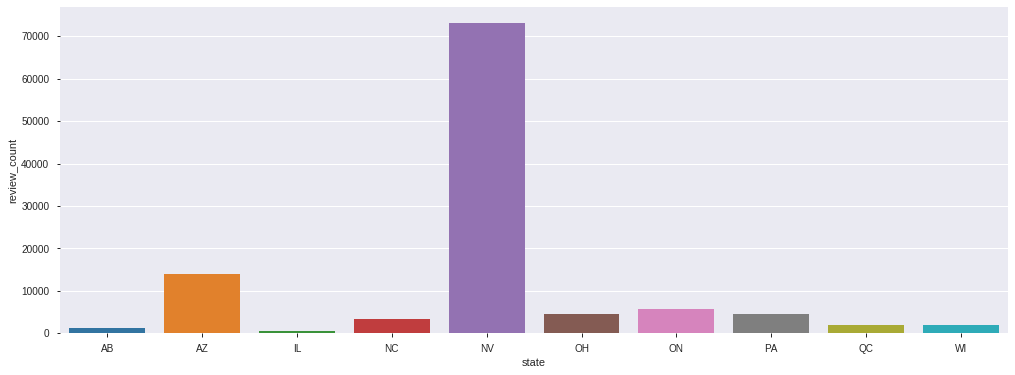

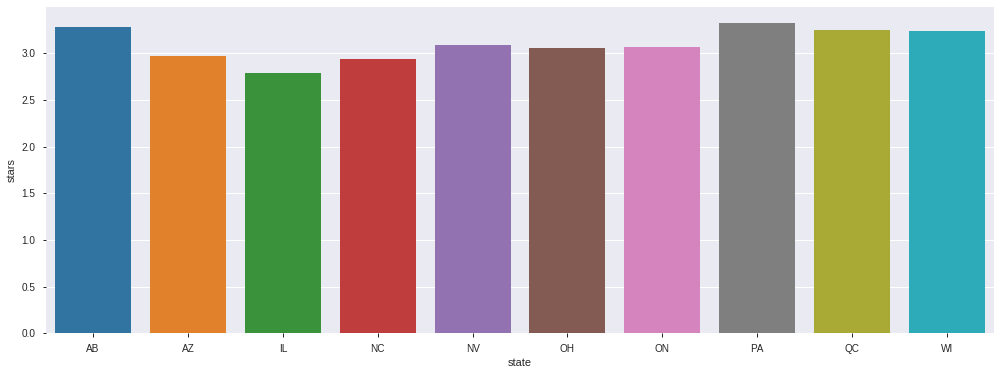

In [83]:
bs_data = pd.read_json('./yelp-dataset/yelp_academic_dataset_business.json',
                       lines=True)

# Filter Hotel
bs_data['name'] = bs_data['name'].str.lower()
bs_data = bs_data[bs_data['name'].str.contains('hotel|motel| inn')]
print('Hotel:', bs_data.shape)

# Filter NY, SC, VT
bs_data = bs_data[~bs_data['state'].isin(['NY', 'SC', 'VT'])]

# H3
bs_data['h3'] = bs_data[['latitude', 'longitude']].apply(
    lambda x: h3.geo_to_h3(x['latitude'], x['longitude'], 7), axis=1)

# State Barplot
review_count_df = bs_data.groupby('state')['review_count'].sum()
plt.figure(figsize=(17, 6))
sns.barplot(review_count_df.index, review_count_df)

review_count_df = bs_data.groupby('state')['stars'].mean()
plt.figure(figsize=(17, 6))
sns.barplot(review_count_df.index, review_count_df)

# Filter State
print('전체:', bs_data.shape)
# bs_data = bs_data[bs_data['state'] == 'NV']
# print('NV:', bs_data.shape)

# Rank & Drop columns
bs_data['rank'] = bs_data['stars'] * bs_data['review_count']
bs_data.drop(['address', 'postal_code', 'hours', 'attributes'], axis=1, inplace=True)

# Category
bs_data['categories'] = bs_data['categories'].str.lower()
bs_data['categories'].fillna('', inplace=True)

# Kepler
bs_m = KeplerGl(height=500)
bs_m.add_data(bs_data)
# bs_m.set_state(pickle.load(open('states/business_map.pickle', 'rb')))

bs_data = bs_data.reset_index().drop('index', axis=1)
bs_data.to_csv('./yelp-dataset/business.csv', index=False)
print('shape:', bs_data.shape)
bs_data.head()

![](images/business01.png)

In [7]:
bs_m

KeplerGl(data={'unnamed': {'index': [48, 88, 129, 143, 210, 475, 489, 585, 634, 670, 737, 980, 1014, 1039, 109…

In [236]:
pickle.dump(bs_m.get_state(), open('states/business_map.pickle', 'wb'))
bs_m.save_to_html(file_name='business.html')
!google-chrome business.html

Map saved to business.html!
Opening in existing browser session.


In [84]:
!embulk guess seed_business.yml -o config_business.yml
!embulk run config_business.yml

2019-10-21 21:10:33.402 +0900: Embulk v0.9.19
2019-10-21 21:10:33.707 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-10-21 21:10:34.947 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-10-21 21:10:35.363 +0900 [INFO] (main): Started Embulk v0.9.19
2019-10-21 21:10:35.400 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'business.csv'
2019-10-21 21:10:35.400 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-10-21 21:10:35.401 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/business.csv]
2019-10-21 21:10:35.408 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-10-21 21:10:35.470 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-10-21 21:10:35.482 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-10-21 21:

2019-10-21 21:10:39.973 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-10-21 21:10:39.974 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016dee39f8a2_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-10-21 21:10:39.975 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-10-21 21:10:39.980 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-10-21 21:10:39.981 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016dee39f8a2_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?

2019-10-21 21:10:40.079 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-10-21 21:10:40.080 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016dee39f8a2_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-10-21 21:10:40.081 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-10-21 21:10:40.086 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-10-21 21:10:40.086 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016dee39f8a2_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?

2019-10-21 21:10:40.200 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-10-21 21:10:40.200 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016dee39f8a2_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-10-21 21:10:40.201 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-10-21 21:10:40.209 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-10-21 21:10:40.209 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016dee39f8a2_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?

2019-10-21 21:10:40.286 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-10-21 21:10:40.286 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016dee39f8a2_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-10-21 21:10:40.287 +0900 [INFO] (0030:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-10-21 21:10:40.289 +0900 [INFO] (0030:task-0000): TransactionIsolation=repeatable_read
2019-10-21 21:10:40.289 +0900 [INFO] (0030:task-0000): Prepared SQL: INSERT INTO `business_0000016dee39f8a2_embulk` (`business_id`, `name`, `city`, `state`, `latitude`, `longitude`, `stars`, `review_count`, `is_open`, `categories`, `h3`, `rank`) VALUES (?

2019-10-21 21:10:41.112 +0900 [INFO] (0030:task-0000): > 0.01 seconds (loaded 89 rows in total)
2019-10-21 21:10:41.112 +0900 [INFO] (0030:task-0000): Loading 86 rows
2019-10-21 21:10:41.121 +0900 [INFO] (0030:task-0000): > 0.01 seconds (loaded 86 rows in total)
2019-10-21 21:10:41.121 +0900 [INFO] (0030:task-0000): Loading 87 rows
2019-10-21 21:10:41.130 +0900 [INFO] (0030:task-0000): > 0.01 seconds (loaded 87 rows in total)
2019-10-21 21:10:41.130 +0900 [INFO] (0030:task-0000): Loading 89 rows
2019-10-21 21:10:41.140 +0900 [INFO] (0030:task-0000): > 0.01 seconds (loaded 89 rows in total)
2019-10-21 21:10:41.140 +0900 [INFO] (0030:task-0000): Loading 88 rows
2019-10-21 21:10:41.148 +0900 [INFO] (0030:task-0000): > 0.01 seconds (loaded 88 rows in total)
2019-10-21 21:10:41.148 +0900 [INFO] (0030:task-0000): Loading 87 rows
2019-10-21 21:10:41.159 +0900 [INFO] (0030:task-0000): > 0.01 seconds (loaded 87 rows in total)
2019-10-21 21:10:41.159 +0900 [INFO] (0030:task-0000): Loading 88 row

In [85]:
conn = pymysql.connect('localhost', 'anderson', db='yelp', charset='utf8')
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_business_on_business_id on business (business_id(40));')
    cursor.execute('create index if not exists idx_business_on_state on business (state(5));')
    cursor.execute('create index if not exists idx_business_on_h3 on business (h3(20));')
cursor.fetchall()

()

### 카테고리 

In [14]:
from collections import Counter

category_df = bs_data['categories'].str.split(',')

counter = {}
for row in category_df:
    if row is None:
        continue
    for category in row:
        category = category.strip().lower()
        counter.setdefault(category, 0)
        counter[category] += 1
counter = Counter(counter)
counter.most_common(10)

[('event planning & services', 1403),
 ('hotels & travel', 1393),
 ('hotels', 1362),
 ('restaurants', 382),
 ('venues & event spaces', 262),
 ('nightlife', 157),
 ('bars', 132),
 ('shopping', 129),
 ('food', 129),
 ('home services', 117)]

### star distribution

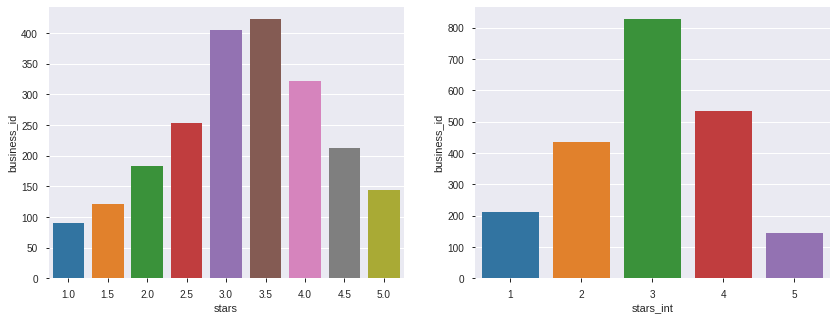

In [22]:
fig, plots = subplots(1, 2, figsize=(14, 5))

star_count = bs_data[['stars', 'business_id']].groupby('stars').count()
sns.barplot(star_count.index, 'business_id', data=star_count, ax=plots[0])

bs_data['stars_int'] = bs_data['stars'].astype('int')
star_count = bs_data[['stars_int', 'business_id']].groupby('stars_int').count()
sns.barplot(star_count.index, 'business_id', data=star_count, ax=plots[1])

## Attributes

In [234]:
# rep1 = {'"True"': 'true', '"False"': 'false', '\'': '"', "u'": '"', '"{': '{', '"}': '}',
#         'True': 'true', 'False': 'false'}
# rep2 = {'""': '"', } 
# regex1 = re.compile('|'.join(rep1.keys()))
# regex2 = re.compile('|'.join(rep2.keys()))

# att_data = []
# with open('yelp-dataset/yelp_academic_dataset_business.json', 'rt') as f:
    
#     for line in f:
#         attribute = json.loads(line)
#         if attribute['attributes'] is None:
#             continue
        
#         attribute = json.dumps(attribute['attributes'])
        
#         attribute = regex1.sub(lambda t: rep1[t.group(0)], attribute)
#         attribute = regex2.sub(lambda t: rep2[t.group(0)], attribute)
        
#         attribute = json.loads(attribute)
        
# #         print(attribute)

JSONDecodeError: Expecting ',' delimiter: line 1 column 156 (char 155)

## Checkin Data

In [24]:
ck_data = pd.read_json('./yelp-dataset/yelp_academic_dataset_checkin.json', lines=True)
print('전체:', ck_data.shape)
ck_data = ck_data[ck_data['business_id'].isin(bs_data['business_id'])]
ck_data.set_index('business_id', inplace=True)
print('NV:', ck_data.shape)

# Preprocessing
def convert_datetimes(x):
    x = pd.to_datetime(x)
    return x
    
dts_df = ck_data['date'].str.split(',').iloc[:10].apply(convert_datetimes)
dts_df = pd.DataFrame(dts_df.tolist(), index=dts_df.index).stack().reset_index()
dts_df.drop('level_1', axis=1, inplace=True)
dts_df.rename({0: 'checkin'}, axis=1, inplace=True)
dts_df['year'] = dts_df['checkin'].dt.year
dts_df['month'] = dts_df['checkin'].dt.month
dts_df['hour'] = dts_df['checkin'].dt.hour

dts_df.to_csv('./yelp-dataset/checkin.csv', index=False)
dts_df.head()

전체: (161950, 2)
NV: (1972, 1)


,business_id,checkin,year,month,hour
0,--Y7NhBKzLTbNliMUX_wfg,2015-03-26 16:47:31,2015,3,16
1,--Y7NhBKzLTbNliMUX_wfg,2015-04-01 20:01:14,2015,4,20
2,-0XFoI1UKfuRKwyAl85zAQ,2012-01-08 02:02:16,2012,1,2
3,-0XFoI1UKfuRKwyAl85zAQ,2012-07-01 23:59:21,2012,7,23
4,-0XFoI1UKfuRKwyAl85zAQ,2012-07-14 10:15:27,2012,7,10


In [25]:
!embulk guess seed_checkin.yml -o config_checkin.yml
!embulk run config_checkin.yml

2019-10-19 21:09:31.625 +0900: Embulk v0.9.19
2019-10-19 21:09:31.979 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-10-19 21:09:33.403 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-10-19 21:09:33.899 +0900 [INFO] (main): Started Embulk v0.9.19
2019-10-19 21:09:33.947 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'checkin.csv'
2019-10-19 21:09:33.948 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-10-19 21:09:33.949 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/checkin.csv]
2019-10-19 21:09:33.957 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-10-19 21:09:34.005 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-10-19 21:09:34.018 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-10-19 21:09

2019-10-19 21:09:40.025 +0900 [INFO] (0016:task-0000): TransactionIsolation=repeatable_read
2019-10-19 21:09:40.025 +0900 [INFO] (0016:task-0000): Prepared SQL: INSERT INTO `checkin_0000016de3ec56c3_embulk` (`business_id`, `checkin`, `year`, `month`, `hour`) VALUES (?, ?, ?, ?, ?)
2019-10-19 21:09:40.142 +0900 [INFO] (0016:task-0000): Loading 265 rows
2019-10-19 21:09:40.169 +0900 [INFO] (0016:task-0000): > 0.03 seconds (loaded 265 rows in total)
2019-10-19 21:09:40.171 +0900 [INFO] (0001:transaction): {done:  1 / 1, running: 0}
2019-10-19 21:09:40.171 +0900 [INFO] (0001:transaction): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=2700000}
2019-10-19 21:09:40.174 +0900 [INFO] (0001:transaction): TransactionIsolation=repeatable_read
2019-10-19 21:09:40.175 +0900 [INFO] (0001:transaction): SQL: DROP TABLE IF EXISTS `checkin`
2019-

In [75]:
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_checkin_on_business_id on checkin (business_id(40));')
    cursor.execute('create index if not exists idx_checkin_on_year on checkin (year);')
    cursor.execute('create index if not exists idx_checkin_on_month on checkin (month);')
    
cursor.fetchall()

()

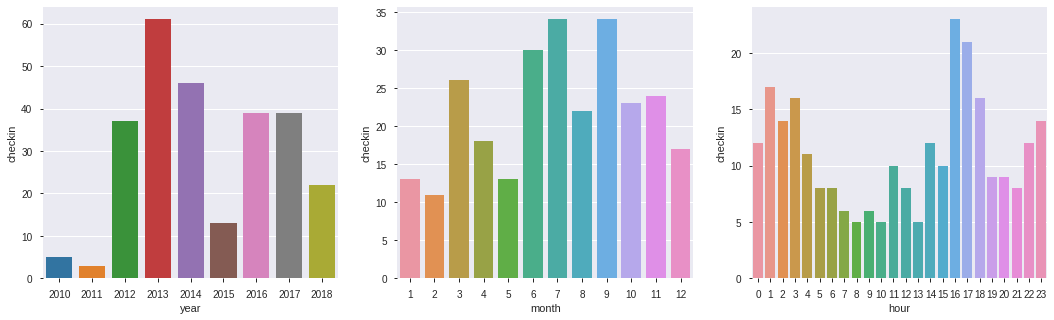

In [26]:
fig, plots = subplots(1, 3, figsize=(18, 5))
plots = plots.reshape(-1)

year_df = dts_df.groupby('year')['checkin'].count()
month_df = dts_df.groupby('month')['checkin'].count()
hour_df = dts_df.groupby('hour')['checkin'].count()

sns.barplot(year_df.index, year_df, ax=plots[0])
sns.barplot(month_df.index, month_df, ax=plots[1])
sns.barplot(hour_df.index, hour_df, ax=plots[2])


## Review

In [381]:
!embulk guess seed_review.yml -o config_review.yml
!embulk run config_review.yml

2019-10-19 18:50:25.313 +0900: Embulk v0.9.19
2019-10-19 18:50:25.655 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-10-19 18:50:27.097 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-10-19 18:50:27.583 +0900 [INFO] (main): Started Embulk v0.9.19
2019-10-19 18:50:27.632 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'yelp_academic_dataset_review.json'
2019-10-19 18:50:27.633 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-10-19 18:50:27.634 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/yelp_academic_dataset_review.json]
2019-10-19 18:50:27.641 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-10-19 18:50:27.688 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-10-19 18:50:27.703 +0900 [INFO] (0001:guess): Lo

2019-10-19 18:50:32.947 +0900 [INFO] (0016:task-0000): TransactionIsolation=repeatable_read
2019-10-19 18:50:32.948 +0900 [INFO] (0016:task-0000): Prepared SQL: INSERT INTO `review_0000016de36cf8ea_embulk` (`review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, `text`, `date`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-10-19 18:50:32.950 +0900 [INFO] (0016:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-10-19 18:50:32.958 +0900 [INFO] (0016:task-0000): TransactionIsolation=repeatable_read
2019-10-19 18:50:32.958 +0900 [INFO] (0016:task-0000): Prepared SQL: INSERT INTO `review_0000016de36cf8ea_embulk` (`review_id`, `user_id`, `business_id`, `stars`, `useful`, `funny`, `cool`, `text`, `date`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-10-19 18:50:32.962 +0900 [INFO] (0016:task-0000): Connecti

2019-10-19 18:50:58.162 +0900 [INFO] (embulk-output-executor-6): > 0.79 seconds (loaded 46,083 rows in total)
2019-10-19 18:50:59.470 +0900 [INFO] (embulk-output-executor-1): Loading 11,419 rows
2019-10-19 18:50:59.470 +0900 [INFO] (embulk-output-executor-2): Loading 11,403 rows
2019-10-19 18:50:59.470 +0900 [INFO] (embulk-output-executor-4): Loading 11,543 rows
2019-10-19 18:51:00.363 +0900 [INFO] (embulk-output-executor-1): > 0.89 seconds (loaded 57,347 rows in total)
2019-10-19 18:51:00.382 +0900 [INFO] (embulk-output-executor-2): > 0.91 seconds (loaded 57,199 rows in total)
2019-10-19 18:51:00.893 +0900 [INFO] (embulk-output-executor-4): > 1.42 seconds (loaded 57,763 rows in total)
2019-10-19 18:51:00.894 +0900 [INFO] (embulk-output-executor-5): Loading 11,433 rows
2019-10-19 18:51:00.895 +0900 [INFO] (embulk-output-executor-7): Loading 11,492 rows
2019-10-19 18:51:00.895 +0900 [INFO] (embulk-output-executor-0): Loading 11,281 rows
2019-10-19 18:51:02.010 +0900 [INFO] (embulk-outpu

2019-10-19 18:51:26.243 +0900 [INFO] (embulk-output-executor-7): > 0.97 seconds (loaded 102,584 rows in total)
2019-10-19 18:51:26.244 +0900 [INFO] (embulk-output-executor-0): Loading 11,520 rows
2019-10-19 18:51:27.072 +0900 [INFO] (embulk-output-executor-0): > 0.83 seconds (loaded 102,587 rows in total)
2019-10-19 18:51:27.074 +0900 [INFO] (embulk-output-executor-6): Loading 11,407 rows
2019-10-19 18:51:27.871 +0900 [INFO] (embulk-output-executor-6): > 0.80 seconds (loaded 102,664 rows in total)
2019-10-19 18:51:29.089 +0900 [INFO] (embulk-output-executor-2): Loading 11,364 rows
2019-10-19 18:51:29.091 +0900 [INFO] (embulk-output-executor-1): Loading 11,287 rows
2019-10-19 18:51:29.988 +0900 [INFO] (embulk-output-executor-1): > 0.90 seconds (loaded 113,661 rows in total)
2019-10-19 18:51:29.998 +0900 [INFO] (embulk-output-executor-2): > 0.91 seconds (loaded 113,795 rows in total)
2019-10-19 18:51:30.000 +0900 [INFO] (embulk-output-executor-5): Loading 11,521 rows
2019-10-19 18:51:30.

2019-10-19 18:51:55.989 +0900 [INFO] (embulk-output-executor-2): > 0.78 seconds (loaded 159,076 rows in total)
2019-10-19 18:51:55.990 +0900 [INFO] (embulk-output-executor-3): Loading 10,922 rows
2019-10-19 18:51:56.497 +0900 [INFO] (embulk-output-executor-4): > 1.29 seconds (loaded 160,209 rows in total)
2019-10-19 18:51:56.498 +0900 [INFO] (embulk-output-executor-7): Loading 11,021 rows
2019-10-19 18:51:56.989 +0900 [INFO] (embulk-output-executor-3): > 1.00 seconds (loaded 159,103 rows in total)
2019-10-19 18:51:57.312 +0900 [INFO] (embulk-output-executor-7): > 0.81 seconds (loaded 159,262 rows in total)
2019-10-19 18:51:57.313 +0900 [INFO] (embulk-output-executor-0): Loading 10,946 rows
2019-10-19 18:51:58.126 +0900 [INFO] (embulk-output-executor-0): > 0.81 seconds (loaded 158,878 rows in total)
2019-10-19 18:51:58.138 +0900 [INFO] (embulk-output-executor-6): Loading 10,975 rows
2019-10-19 18:51:59.143 +0900 [INFO] (embulk-output-executor-6): > 1.01 seconds (loaded 159,371 rows in t

2019-10-19 18:52:26.280 +0900 [INFO] (embulk-output-executor-4): > 0.96 seconds (loaded 216,832 rows in total)
2019-10-19 18:52:26.284 +0900 [INFO] (embulk-output-executor-1): Loading 11,273 rows
2019-10-19 18:52:27.036 +0900 [INFO] (embulk-output-executor-1): > 0.75 seconds (loaded 215,305 rows in total)
2019-10-19 18:52:27.042 +0900 [INFO] (embulk-output-executor-5): Loading 11,418 rows
2019-10-19 18:52:27.044 +0900 [INFO] (embulk-output-executor-2): Loading 11,523 rows
2019-10-19 18:52:27.924 +0900 [INFO] (embulk-output-executor-2): > 0.88 seconds (loaded 215,819 rows in total)
2019-10-19 18:52:27.938 +0900 [INFO] (embulk-output-executor-5): > 0.90 seconds (loaded 215,468 rows in total)
2019-10-19 18:52:27.942 +0900 [INFO] (embulk-output-executor-7): Loading 11,538 rows
2019-10-19 18:52:27.944 +0900 [INFO] (embulk-output-executor-3): Loading 11,460 rows
2019-10-19 18:52:28.862 +0900 [INFO] (embulk-output-executor-3): > 0.92 seconds (loaded 216,137 rows in total)
2019-10-19 18:52:28.

2019-10-19 18:52:55.451 +0900 [INFO] (embulk-output-executor-0): > 0.77 seconds (loaded 260,887 rows in total)
2019-10-19 18:52:55.470 +0900 [INFO] (embulk-output-executor-6): Loading 11,318 rows
2019-10-19 18:52:56.259 +0900 [INFO] (embulk-output-executor-6): > 0.79 seconds (loaded 261,078 rows in total)
2019-10-19 18:52:57.445 +0900 [INFO] (embulk-output-executor-4): Loading 11,525 rows
2019-10-19 18:52:58.250 +0900 [INFO] (embulk-output-executor-4): > 0.80 seconds (loaded 273,398 rows in total)
2019-10-19 18:52:58.257 +0900 [INFO] (embulk-output-executor-1): Loading 11,443 rows
2019-10-19 18:52:58.257 +0900 [INFO] (embulk-output-executor-2): Loading 11,175 rows
2019-10-19 18:52:59.405 +0900 [INFO] (embulk-output-executor-2): > 1.15 seconds (loaded 271,708 rows in total)
2019-10-19 18:52:59.416 +0900 [INFO] (embulk-output-executor-1): > 1.16 seconds (loaded 271,773 rows in total)
2019-10-19 18:52:59.421 +0900 [INFO] (embulk-output-executor-3): Loading 11,355 rows
2019-10-19 18:52:59.

2019-10-19 18:53:24.866 +0900 [INFO] (embulk-output-executor-3): > 0.90 seconds (loaded 318,110 rows in total)
2019-10-19 18:53:24.875 +0900 [INFO] (embulk-output-executor-7): > 0.91 seconds (loaded 318,093 rows in total)
2019-10-19 18:53:24.877 +0900 [INFO] (embulk-output-executor-0): Loading 11,469 rows
2019-10-19 18:53:25.871 +0900 [INFO] (embulk-output-executor-0): > 0.99 seconds (loaded 318,058 rows in total)
2019-10-19 18:53:25.887 +0900 [INFO] (embulk-output-executor-6): Loading 11,359 rows
2019-10-19 18:53:26.649 +0900 [INFO] (embulk-output-executor-6): > 0.76 seconds (loaded 318,355 rows in total)
2019-10-19 18:53:27.798 +0900 [INFO] (embulk-output-executor-4): Loading 10,979 rows
2019-10-19 18:53:28.584 +0900 [INFO] (embulk-output-executor-4): > 0.79 seconds (loaded 329,897 rows in total)
2019-10-19 18:53:28.589 +0900 [INFO] (embulk-output-executor-2): Loading 10,899 rows
2019-10-19 18:53:28.590 +0900 [INFO] (embulk-output-executor-5): Loading 10,907 rows
2019-10-19 18:53:29.

2019-10-19 18:53:53.718 +0900 [INFO] (embulk-output-executor-1): > 0.80 seconds (loaded 373,500 rows in total)
2019-10-19 18:53:53.722 +0900 [INFO] (embulk-output-executor-3): Loading 11,232 rows
2019-10-19 18:53:54.622 +0900 [INFO] (embulk-output-executor-3): > 0.90 seconds (loaded 374,152 rows in total)
2019-10-19 18:53:54.624 +0900 [INFO] (embulk-output-executor-7): Loading 11,263 rows
2019-10-19 18:53:54.624 +0900 [INFO] (embulk-output-executor-0): Loading 11,301 rows
2019-10-19 18:53:55.520 +0900 [INFO] (embulk-output-executor-7): > 0.90 seconds (loaded 374,283 rows in total)
2019-10-19 18:53:55.538 +0900 [INFO] (embulk-output-executor-0): > 0.91 seconds (loaded 374,169 rows in total)
2019-10-19 18:53:55.564 +0900 [INFO] (embulk-output-executor-6): Loading 11,335 rows
2019-10-19 18:53:56.387 +0900 [INFO] (embulk-output-executor-6): > 0.82 seconds (loaded 374,160 rows in total)
2019-10-19 18:53:57.589 +0900 [INFO] (embulk-output-executor-4): Loading 11,180 rows
2019-10-19 18:53:58.

2019-10-19 18:54:26.959 +0900 [INFO] (embulk-output-executor-2): > 0.78 seconds (loaded 429,373 rows in total)
2019-10-19 18:54:26.962 +0900 [INFO] (embulk-output-executor-1): Loading 11,510 rows
2019-10-19 18:54:26.964 +0900 [INFO] (embulk-output-executor-5): Loading 11,498 rows
2019-10-19 18:54:27.871 +0900 [INFO] (embulk-output-executor-1): > 0.91 seconds (loaded 429,352 rows in total)
2019-10-19 18:54:27.889 +0900 [INFO] (embulk-output-executor-5): > 0.93 seconds (loaded 429,492 rows in total)
2019-10-19 18:54:27.903 +0900 [INFO] (embulk-output-executor-3): Loading 11,477 rows
2019-10-19 18:54:27.905 +0900 [INFO] (embulk-output-executor-7): Loading 11,454 rows
2019-10-19 18:54:28.693 +0900 [INFO] (embulk-output-executor-3): > 0.79 seconds (loaded 430,025 rows in total)
2019-10-19 18:54:29.189 +0900 [INFO] (embulk-output-executor-7): > 1.28 seconds (loaded 430,539 rows in total)
2019-10-19 18:54:29.190 +0900 [INFO] (embulk-output-executor-0): Loading 11,442 rows
2019-10-19 18:54:29.

2019-10-19 18:54:57.713 +0900 [INFO] (embulk-output-executor-6): Loading 11,252 rows
2019-10-19 18:54:58.509 +0900 [INFO] (embulk-output-executor-6): > 0.80 seconds (loaded 475,428 rows in total)
2019-10-19 18:54:59.759 +0900 [INFO] (embulk-output-executor-4): Loading 11,246 rows
2019-10-19 18:55:00.562 +0900 [INFO] (embulk-output-executor-4): > 0.80 seconds (loaded 488,028 rows in total)
2019-10-19 18:55:00.566 +0900 [INFO] (embulk-output-executor-2): Loading 11,452 rows
2019-10-19 18:55:01.362 +0900 [INFO] (embulk-output-executor-2): > 0.80 seconds (loaded 486,673 rows in total)
2019-10-19 18:55:01.373 +0900 [INFO] (embulk-output-executor-1): Loading 11,154 rows
2019-10-19 18:55:01.375 +0900 [INFO] (embulk-output-executor-5): Loading 11,297 rows
2019-10-19 18:55:02.286 +0900 [INFO] (embulk-output-executor-1): > 0.91 seconds (loaded 486,339 rows in total)
2019-10-19 18:55:02.349 +0900 [INFO] (embulk-output-executor-5): > 0.97 seconds (loaded 486,500 rows in total)
2019-10-19 18:55:02.

2019-10-19 18:55:32.544 +0900 [INFO] (embulk-output-executor-3): > 1.02 seconds (loaded 532,402 rows in total)
2019-10-19 18:55:32.546 +0900 [INFO] (embulk-output-executor-7): Loading 11,620 rows
2019-10-19 18:55:33.310 +0900 [INFO] (embulk-output-executor-7): > 0.76 seconds (loaded 533,207 rows in total)
2019-10-19 18:55:33.311 +0900 [INFO] (embulk-output-executor-0): Loading 11,543 rows
2019-10-19 18:55:34.094 +0900 [INFO] (embulk-output-executor-0): > 0.78 seconds (loaded 532,455 rows in total)
2019-10-19 18:55:34.109 +0900 [INFO] (embulk-output-executor-6): Loading 11,450 rows
2019-10-19 18:55:34.883 +0900 [INFO] (embulk-output-executor-6): > 0.77 seconds (loaded 531,808 rows in total)
2019-10-19 18:55:36.008 +0900 [INFO] (embulk-output-executor-4): Loading 11,423 rows
2019-10-19 18:55:36.861 +0900 [INFO] (embulk-output-executor-4): > 0.85 seconds (loaded 544,769 rows in total)
2019-10-19 18:55:36.868 +0900 [INFO] (embulk-output-executor-2): Loading 11,607 rows
2019-10-19 18:55:37.

2019-10-19 18:56:08.065 +0900 [INFO] (embulk-output-executor-1): > 0.91 seconds (loaded 588,184 rows in total)
2019-10-19 18:56:08.069 +0900 [INFO] (embulk-output-executor-5): Loading 11,139 rows
2019-10-19 18:56:08.869 +0900 [INFO] (embulk-output-executor-5): > 0.80 seconds (loaded 588,313 rows in total)
2019-10-19 18:56:08.874 +0900 [INFO] (embulk-output-executor-3): Loading 11,135 rows
2019-10-19 18:56:08.875 +0900 [INFO] (embulk-output-executor-7): Loading 11,196 rows
2019-10-19 18:56:08.875 +0900 [INFO] (embulk-output-executor-0): Loading 11,132 rows
2019-10-19 18:56:09.718 +0900 [INFO] (embulk-output-executor-0): > 0.84 seconds (loaded 588,782 rows in total)
2019-10-19 18:56:10.580 +0900 [INFO] (embulk-output-executor-3): > 1.71 seconds (loaded 589,023 rows in total)
2019-10-19 18:56:10.595 +0900 [INFO] (embulk-output-executor-7): > 1.72 seconds (loaded 589,742 rows in total)
2019-10-19 18:56:10.611 +0900 [INFO] (embulk-output-executor-6): Loading 11,241 rows
2019-10-19 18:56:11.

2019-10-19 18:56:42.379 +0900 [INFO] (embulk-output-executor-4): Loading 11,296 rows
2019-10-19 18:56:43.197 +0900 [INFO] (embulk-output-executor-4): > 0.82 seconds (loaded 646,735 rows in total)
2019-10-19 18:56:43.203 +0900 [INFO] (embulk-output-executor-2): Loading 11,396 rows
2019-10-19 18:56:43.999 +0900 [INFO] (embulk-output-executor-2): > 0.80 seconds (loaded 645,464 rows in total)
2019-10-19 18:56:44.007 +0900 [INFO] (embulk-output-executor-1): Loading 11,201 rows
2019-10-19 18:56:44.791 +0900 [INFO] (embulk-output-executor-1): > 0.78 seconds (loaded 644,937 rows in total)
2019-10-19 18:56:44.798 +0900 [INFO] (embulk-output-executor-5): Loading 11,349 rows
2019-10-19 18:56:45.576 +0900 [INFO] (embulk-output-executor-5): > 0.78 seconds (loaded 645,471 rows in total)
2019-10-19 18:56:45.588 +0900 [INFO] (embulk-output-executor-7): Loading 11,296 rows
2019-10-19 18:56:46.362 +0900 [INFO] (embulk-output-executor-7): > 0.77 seconds (loaded 646,474 rows in total)
2019-10-19 18:56:46.

2019-10-19 18:57:13.901 +0900 [INFO] (embulk-output-executor-3): Loading 11,322 rows
2019-10-19 18:57:14.863 +0900 [INFO] (embulk-output-executor-3): > 0.96 seconds (loaded 690,356 rows in total)
2019-10-19 18:57:14.890 +0900 [INFO] (embulk-output-executor-6): Loading 11,254 rows
2019-10-19 18:57:15.664 +0900 [INFO] (embulk-output-executor-6): > 0.77 seconds (loaded 690,647 rows in total)
2019-10-19 18:57:16.807 +0900 [INFO] (embulk-output-executor-4): Loading 11,213 rows
2019-10-19 18:57:17.608 +0900 [INFO] (embulk-output-executor-4): > 0.80 seconds (loaded 702,607 rows in total)
2019-10-19 18:57:17.613 +0900 [INFO] (embulk-output-executor-1): Loading 11,271 rows
2019-10-19 18:57:17.614 +0900 [INFO] (embulk-output-executor-2): Loading 11,289 rows
2019-10-19 18:57:18.504 +0900 [INFO] (embulk-output-executor-1): > 0.89 seconds (loaded 700,788 rows in total)
2019-10-19 18:57:18.513 +0900 [INFO] (embulk-output-executor-2): > 0.90 seconds (loaded 701,762 rows in total)
2019-10-19 18:57:18.

2019-10-19 18:57:46.835 +0900 [INFO] (embulk-output-executor-5): > 0.79 seconds (loaded 746,386 rows in total)
2019-10-19 18:57:46.844 +0900 [INFO] (embulk-output-executor-7): Loading 10,948 rows
2019-10-19 18:57:47.785 +0900 [INFO] (embulk-output-executor-7): > 0.94 seconds (loaded 747,133 rows in total)
2019-10-19 18:57:47.786 +0900 [INFO] (embulk-output-executor-0): Loading 10,822 rows
2019-10-19 18:57:48.561 +0900 [INFO] (embulk-output-executor-0): > 0.78 seconds (loaded 746,085 rows in total)
2019-10-19 18:57:48.562 +0900 [INFO] (embulk-output-executor-3): Loading 10,844 rows
2019-10-19 18:57:49.353 +0900 [INFO] (embulk-output-executor-3): > 0.79 seconds (loaded 746,295 rows in total)
2019-10-19 18:57:49.355 +0900 [INFO] (embulk-output-executor-6): Loading 10,745 rows
2019-10-19 18:57:50.360 +0900 [INFO] (embulk-output-executor-6): > 1.01 seconds (loaded 746,468 rows in total)
2019-10-19 18:57:51.484 +0900 [INFO] (embulk-output-executor-4): Loading 11,009 rows
2019-10-19 18:57:52.

2019-10-19 18:58:20.533 +0900 [INFO] (embulk-output-executor-4): > 1.21 seconds (loaded 803,888 rows in total)
2019-10-19 18:58:20.543 +0900 [INFO] (embulk-output-executor-1): > 1.22 seconds (loaded 801,818 rows in total)
2019-10-19 18:58:20.546 +0900 [INFO] (embulk-output-executor-2): Loading 11,471 rows
2019-10-19 18:58:21.389 +0900 [INFO] (embulk-output-executor-2): > 0.84 seconds (loaded 803,041 rows in total)
2019-10-19 18:58:21.403 +0900 [INFO] (embulk-output-executor-5): Loading 11,286 rows
2019-10-19 18:58:22.214 +0900 [INFO] (embulk-output-executor-5): > 0.81 seconds (loaded 803,040 rows in total)
2019-10-19 18:58:22.235 +0900 [INFO] (embulk-output-executor-0): Loading 11,311 rows
2019-10-19 18:58:22.237 +0900 [INFO] (embulk-output-executor-7): Loading 11,517 rows
2019-10-19 18:58:23.106 +0900 [INFO] (embulk-output-executor-7): > 0.87 seconds (loaded 803,872 rows in total)
2019-10-19 18:58:23.135 +0900 [INFO] (embulk-output-executor-0): > 0.90 seconds (loaded 802,944 rows in t

In [76]:
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_review_on_user_id on review (user_id(40));')
    cursor.execute('create index if not exists idx_review_on_business_id on review (business_id(40));')
    cursor.execute('create index if not exists idx_review_on_date on review (date);')
    
cursor.fetchall()

/usr/local/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1061, "Duplicate key name 'idx_review_on_user_id'")
  result = self._query(query)
/usr/local/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1061, "Duplicate key name 'idx_review_on_business_id'")
  result = self._query(query)
/usr/local/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1061, "Duplicate key name 'idx_review_on_date'")
  result = self._query(query)


()

## Tip Data


In [521]:
!embulk guess seed_tip.yml -o config_tip.yml
!embulk run config_tip.yml

2019-10-19 20:20:52.032 +0900: Embulk v0.9.19
2019-10-19 20:20:52.531 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-10-19 20:20:54.430 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-10-19 20:20:55.041 +0900 [INFO] (main): Started Embulk v0.9.19
2019-10-19 20:20:55.098 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'yelp_academic_dataset_tip.json'
2019-10-19 20:20:55.099 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-10-19 20:20:55.101 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/yelp_academic_dataset_tip.json]
2019-10-19 20:20:55.113 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-10-19 20:20:55.198 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-10-19 20:20:55.216 +0900 [INFO] (0001:guess): Loaded p

2019-10-19 20:21:05.409 +0900 [INFO] (embulk-output-executor-1): Loading 52,921 rows
2019-10-19 20:21:05.409 +0900 [INFO] (embulk-output-executor-0): Loading 53,035 rows
2019-10-19 20:21:05.411 +0900 [INFO] (embulk-output-executor-2): Loading 52,894 rows
2019-10-19 20:21:05.412 +0900 [INFO] (embulk-output-executor-3): Loading 52,907 rows
2019-10-19 20:21:05.414 +0900 [INFO] (embulk-output-executor-6): Loading 52,947 rows
2019-10-19 20:21:05.415 +0900 [INFO] (embulk-output-executor-7): Loading 53,066 rows
2019-10-19 20:21:05.420 +0900 [INFO] (embulk-output-executor-4): Loading 52,857 rows
2019-10-19 20:21:05.426 +0900 [INFO] (embulk-output-executor-5): Loading 52,955 rows
2019-10-19 20:21:10.637 +0900 [INFO] (embulk-output-executor-3): > 5.22 seconds (loaded 52,907 rows in total)
2019-10-19 20:21:10.637 +0900 [INFO] (embulk-output-executor-6): > 5.22 seconds (loaded 52,947 rows in total)
2019-10-19 20:21:10.868 +0900 [INFO] (embulk-output-executor-2): > 5.46 seconds (loaded 52,894 rows 

In [78]:
with conn.cursor() as cursor:
    cursor.execute('create index if not exists idx_tip_on_user_id on tip (user_id(40));')
    cursor.execute('create index if not exists idx_tip_on_business_id on tip (business_id(40));')
    cursor.execute('create index if not exists idx_tip_on_date on tip (date);')
    
cursor.fetchall()

()

## User

In [1]:
!embulk guess seed_user.yml -o config_user.yml
!embulk run config_user.yml

2019-10-19 20:45:14.125 +0900: Embulk v0.9.19
2019-10-19 20:45:14.472 +0900 [WARN] (main): DEPRECATION: JRuby org.jruby.embed.ScriptingContainer is directly injected.
2019-10-19 20:45:15.898 +0900 [INFO] (main): Gem's home and path are set by default: "/home/anderson/.embulk/lib/gems"
2019-10-19 20:45:16.414 +0900 [INFO] (main): Started Embulk v0.9.19
2019-10-19 20:45:16.458 +0900 [INFO] (0001:guess): Listing local files at directory './yelp-dataset' filtering filename by prefix 'yelp_academic_dataset_user.json'
2019-10-19 20:45:16.458 +0900 [INFO] (0001:guess): "follow_symlinks" is set false. Note that symbolic links to directories are skipped.
2019-10-19 20:45:16.459 +0900 [INFO] (0001:guess): Loading files [./yelp-dataset/yelp_academic_dataset_user.json]
2019-10-19 20:45:16.466 +0900 [INFO] (0001:guess): Try to read 32,768 bytes from input source
2019-10-19 20:45:16.519 +0900 [INFO] (0001:guess): Loaded plugin embulk (0.9.19)
2019-10-19 20:45:16.535 +0900 [INFO] (0001:guess): Loaded

2019-10-19 20:45:21.489 +0900 [INFO] (0016:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcpKeepAlive=true, useSSL=false, useCompression=true, rewriteBatchedStatements=true, connectTimeout=300000, socketTimeout=1800000}
2019-10-19 20:45:21.497 +0900 [INFO] (0016:task-0000): TransactionIsolation=repeatable_read
2019-10-19 20:45:21.497 +0900 [INFO] (0016:task-0000): Prepared SQL: INSERT INTO `user_0000016de3d61558_embulk` (`user_id`, `name`, `review_count`, `useful`, `funny`, `cool`, `elite`, `fans`, `average_stars`, `compliment_hot`, `compliment_more`, `compliment_profile`, `compliment_cute`, `compliment_list`, `compliment_note`, `compliment_plain`, `compliment_cool`, `compliment_funny`, `compliment_writer`, `compliment_photos`) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
2019-10-19 20:45:21.501 +0900 [INFO] (0016:task-0000): Connecting to jdbc:mysql://localhost:3306/yelp options {user=anderson, password=***, tcp

2019-10-19 20:46:02.097 +0900 [INFO] (embulk-output-executor-3): > 3.72 seconds (loaded 159,280 rows in total)
2019-10-19 20:46:02.100 +0900 [INFO] (embulk-output-executor-4): Loading 53,373 rows
2019-10-19 20:46:02.276 +0900 [INFO] (embulk-output-executor-1): > 3.89 seconds (loaded 159,427 rows in total)
2019-10-19 20:46:02.276 +0900 [INFO] (embulk-output-executor-5): > 3.90 seconds (loaded 159,302 rows in total)
2019-10-19 20:46:02.280 +0900 [INFO] (embulk-output-executor-6): Loading 53,362 rows
2019-10-19 20:46:02.290 +0900 [INFO] (embulk-output-executor-7): Loading 53,374 rows
2019-10-19 20:46:02.425 +0900 [INFO] (embulk-output-executor-0): > 4.04 seconds (loaded 159,441 rows in total)
2019-10-19 20:46:02.431 +0900 [INFO] (embulk-output-executor-2): Loading 53,372 rows
2019-10-19 20:46:05.076 +0900 [INFO] (embulk-output-executor-4): > 2.98 seconds (loaded 159,447 rows in total)
2019-10-19 20:46:05.984 +0900 [INFO] (embulk-output-executor-2): > 3.55 seconds (loaded 159,585 rows in t

In [ ]:
with conn.cursor() as cursor:
    cursor.execute('create index idx_user_on_user_id on user (user_id(40));')
    
cursor.fetchall()